In [14]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(rc={'figure.figsize':(7,5), 'font.size' : 8})
sns.set_style('white')
warnings.filterwarnings('ignore')
random_seed = 500

In [2]:
df = pd.read_csv('data.csv', delimiter=',')
df = df[df['is_weekend'] == 0]
df = df[df['is_holiday'] == 0]
df.drop(['timestamp', 'is_weekend', 'is_holiday'], inplace = True, axis = 1)
df.head(10)

,month,hour,t1,t2,hum,wind_speed,weather_code,season,cnt
24,1,0,4.0,3.0,93.0,6.0,4,3,83
25,1,1,4.0,3.5,93.0,5.0,4,3,67
26,1,2,5.0,4.0,87.0,6.0,4,3,32
27,1,3,6.0,4.5,84.0,7.5,4,3,22
28,1,4,6.5,5.0,84.0,8.0,4,3,38
29,1,5,6.0,5.5,87.0,5.0,4,3,81
30,1,6,7.0,6.5,81.0,5.0,3,3,444
31,1,7,7.0,6.0,81.0,6.5,3,3,1597
32,1,8,8.0,7.5,79.0,5.0,3,3,3161
33,1,9,8.0,7.0,82.0,6.0,3,3,1342


In [3]:
df.describe()

,month,hour,t1,t2,hum,wind_speed,weather_code,season,cnt
count,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000,12060.000000
mean,6.535240,11.505556,12.537396,11.613723,71.965381,15.858333,2.651658,1.499005,1223.276783
std,3.438754,6.917163,5.612938,6.631535,14.380303,7.748994,2.235115,1.107723,1142.314318
min,1.000000,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,9.000000
25%,4.000000,6.000000,8.500000,6.000000,62.375000,10.000000,1.000000,1.000000,269.000000
50%,7.000000,12.000000,12.500000,12.500000,74.500000,15.000000,2.000000,1.000000,947.000000
75%,10.000000,17.000000,16.500000,16.500000,82.000000,20.500000,3.000000,2.000000,1753.250000
max,12.000000,23.000000,34.000000,34.000000,100.000000,56.500000,26.000000,3.000000,7860.000000


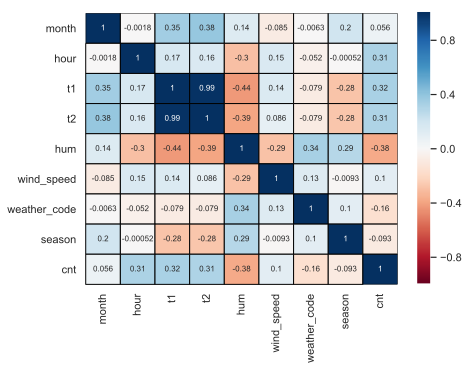

In [15]:
_ = sns.heatmap(df.corr(), cmap="RdBu", linecolor='black', linewidths = 1, vmin = -1, vmax = 1, annot = True)

In [5]:
test_precent = 0.2
train_precent = 1.0 - test_precent
train_data = df.sample(frac=train_precent, random_state=random_seed)
test_data = df.drop(train_data.index)
train_stats = train_data.describe().T
def normalize(x):
    result = x.copy()
    for feature_name in x.columns:
        average = x[feature_name].mean()
        std = x[feature_name].std()
        result[feature_name] = (x[feature_name] - average) / std
    return result
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)
normalized_train_data.head()

,month,hour,t1,t2,hum,wind_speed,weather_code,season,cnt
5774,0.719550,-0.936252,-0.183998,-0.016400,0.906740,-0.884776,-0.744221,0.451524,-0.963566
2067,-1.026920,-0.214516,-0.273105,-0.091817,-1.528435,3.839612,-0.289026,-1.356071,-0.311837
9292,-1.609076,-1.513641,-0.896861,-1.223069,-0.554365,1.315624,-0.744221,1.355322,-1.040699
7064,1.010628,0.651567,0.261542,0.360685,0.698011,-0.237600,0.166169,0.451524,0.556558
879,-1.317998,0.651567,-0.540429,-0.468901,-0.554365,-1.143647,-0.289026,1.355322,0.172627


In [6]:
y_label='cnt'
train_x = normalized_train_data.drop(y_label, axis = 1)
train_y = normalized_train_data[y_label]
test_x = normalized_test_data.drop(y_label, axis = 1)
test_y = normalized_test_data[y_label]


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

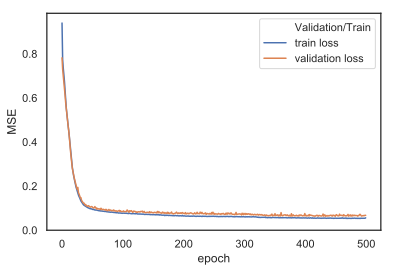

In [7]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

def show_history(history):
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    history_df['train loss'] = history_df['loss']
    history_df['validation loss'] = history_df['val_loss']
    melted = history_df.melt(id_vars=['epoch'], var_name='Validation/Train', value_vars=['train loss', 'validation loss'], value_name='MSE')
    sns.lineplot(data = melted, y='MSE', x='epoch', hue='Validation/Train')
#     sns.lineplot(data = history_df, y='validation loss', x='epoch', color='magenta')
    plt.gca().set_ylim(bottom=0)

def nn_mse(X,y, test_X, test_y):
    inputs_len = len(X.columns)
    input1 = Input(shape=(inputs_len,))
    hidden1 = Dense(inputs_len, activation='relu')(input1)
    hidden2 = Dense(inputs_len, activation='relu')(hidden1)
    out1 = Dense(1)(hidden2)
    model = Model(inputs=input1, outputs=out1)
    model.compile(loss='mean_squared_error', optimizer='adam')
    mc = ModelCheckpoint('best_nn_model.nn', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
    callbacks=[mc, es, PrintDot()]
    history = model.fit(X, y, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=callbacks)
    show_history(history)
    predicted = model.predict(X).flatten()
    expected = y
    train_NN_res = mean_squared_error(expected, predicted)
    predicted = model.predict(test_X).flatten()
    expected = test_y
    test_NN_res = mean_squared_error(expected, predicted)
    return train_NN_res, test_NN_res
train_NN_res, test_NN_res = nn_mse(train_x,train_y, test_x, test_y)

In [8]:
def fit_predict_mse_test(regressor, train_X, train_Y, test_X, test_Y):
    regressor.fit(train_X,train_Y)
    expected = regressor.predict(test_X)
    return mean_squared_error(expected, test_Y)
def fit_predict_mse_train(regressor, train_X, train_Y, test_X, test_Y):
    regressor.fit(train_X,train_Y)
    expected = regressor.predict(train_X)
    return mean_squared_error(expected, train_Y)

In [9]:
results_df = pd.DataFrame(columns=['Classifier', 'Test MSE'])
def predict_and_add_to_df(data_frame, name, regressor):
    return data_frame.append({'Classifier': name, 'Test MSE': fit_predict_mse_test(regressor, train_x, train_y, test_x, test_y)}, ignore_index = True)
    
#results_df = results_df.append({'Classifier': 'NN', 'MSE': nn_mse(X,y)}, ignore_index = True)
results_df = predict_and_add_to_df(results_df, 'KNN5', KNeighborsRegressor(5))
results_df = predict_and_add_to_df(results_df, 'KNN7', KNeighborsRegressor(7))
results_df = predict_and_add_to_df(results_df, 'KNN9', KNeighborsRegressor(9))
results_df = predict_and_add_to_df(results_df, 'Linear', LinearRegression())
results_df = predict_and_add_to_df(results_df, 'SVM', SVR())
results_df = predict_and_add_to_df(results_df, 'DTree2', DecisionTreeRegressor(max_depth = 2))
results_df = predict_and_add_to_df(results_df, 'DTree3', DecisionTreeRegressor(max_depth = 3))
results_df = predict_and_add_to_df(results_df, 'DTree4', DecisionTreeRegressor(max_depth = 4))
results_df = predict_and_add_to_df(results_df, 'DTree5', DecisionTreeRegressor(max_depth = 5))
results_df = results_df.sort_values(by = 'Test MSE').reset_index().drop(columns=['index'])

# Test Set

In [10]:
results_df_train = pd.DataFrame(columns=['Classifier', 'Train MSE'])
def predict_and_add_to_df_train(data_frame, name, regressor):
    return data_frame.append({'Classifier': name, 'Train MSE': fit_predict_mse_train(regressor, train_x, train_y, test_x, test_y)}, ignore_index = True)
    
results_df_train = predict_and_add_to_df_train(results_df_train, 'KNN5', KNeighborsRegressor(5))
results_df_train = predict_and_add_to_df_train(results_df_train, 'KNN7', KNeighborsRegressor(7))
results_df_train = predict_and_add_to_df_train(results_df_train, 'KNN9', KNeighborsRegressor(9))
results_df_train = predict_and_add_to_df_train(results_df_train, 'Linear', LinearRegression())
results_df_train = predict_and_add_to_df_train(results_df_train, 'SVM', SVR())
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree2', DecisionTreeRegressor(max_depth = 2))
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree3', DecisionTreeRegressor(max_depth = 3))
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree4', DecisionTreeRegressor(max_depth = 4))
results_df_train = predict_and_add_to_df_train(results_df_train, 'DTree5', DecisionTreeRegressor(max_depth = 5))
results_df_train = results_df_train.sort_values(by = 'Train MSE').reset_index().drop(columns=['index'])

#  Train Set

In [11]:
results_df['Train MSE'] = results_df_train['Train MSE']
melted_df = results_df.melt(id_vars=['Classifier'], value_vars=['Test MSE', 'Train MSE'])
melted_df.rename(columns={'variable': 'Data-Set', 'value': 'MSE'}, inplace=True)
melted_df = melted_df.append({'Classifier' : 'NN' , 'Data-Set' : 'Test MSE', 'MSE' : test_NN_res} , ignore_index=True)
melted_df = melted_df.append({'Classifier' : 'NN' , 'Data-Set' : 'Train MSE', 'MSE' : train_NN_res} , ignore_index=True)
melted_df = melted_df.sort_values(['MSE'])
melted_df

,Classifier,Data-Set,MSE
19,NN,Train MSE,0.055791
18,NN,Test MSE,0.067985
9,DTree5,Train MSE,0.149232
0,DTree5,Test MSE,0.160379
10,DTree4,Train MSE,0.215179
1,DTree4,Test MSE,0.236101
11,DTree3,Train MSE,0.266360
12,KNN7,Train MSE,0.303339
13,KNN5,Train MSE,0.326893
14,KNN9,Train MSE,0.363419


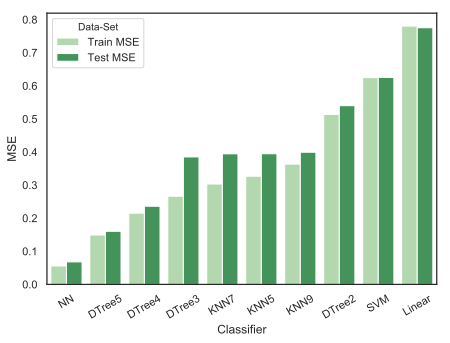

In [16]:
barplot = sns.barplot(data = melted_df, x = 'Classifier', y = 'MSE', hue = 'Data-Set', palette="Greens")
_ = barplot.set_xticklabels(barplot.get_xticklabels(), rotation=30)